In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
df = pd.read_csv("hitters.csv")
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,nan,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500,N


In [6]:
df.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,263.000
mean,380.929,101.025,10.770,50.910,48.028,38.742,7.444,2648.683,717.571,69.491,358.795,330.118,260.239,288.938,106.913,8.040,535.926
std,153.405,46.455,8.709,26.024,26.167,21.639,4.926,2324.206,654.473,86.266,334.106,333.220,267.058,280.705,136.855,6.368,451.119
min,16.000,1.000,0.000,0.000,0.000,0.000,1.000,19.000,4.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,67.500
25%,255.250,64.000,4.000,30.250,28.000,22.000,4.000,816.750,209.000,14.000,100.250,88.750,67.250,109.250,7.000,3.000,190.000
50%,379.500,96.000,8.000,48.000,44.000,35.000,6.000,1928.000,508.000,37.500,247.000,220.500,170.500,212.000,39.500,6.000,425.000
75%,512.000,137.000,16.000,69.000,64.750,53.000,11.000,3924.250,1059.250,90.000,526.250,426.250,339.250,325.000,166.000,11.000,750.000
max,687.000,238.000,40.000,130.000,121.000,105.000,24.000,14053.000,4256.000,548.000,2165.000,1659.000,1566.000,1378.000,492.000,32.000,2460.000


In [7]:
def check_df(dataframe):
    print(f"Shape: {dataframe.shape}\n")
    print(f"Types\n{dataframe.dtypes}\n")
    print(f"NA\n{dataframe.isnull().sum()}")

In [8]:
check_df(df)

Shape: (322, 20)

Types
AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

NA
AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64


In [9]:
df["Salary"].describe()

count    263.000
mean     535.926
std      451.119
min       67.500
25%      190.000
50%      425.000
75%      750.000
max     2460.000
Name: Salary, dtype: float64

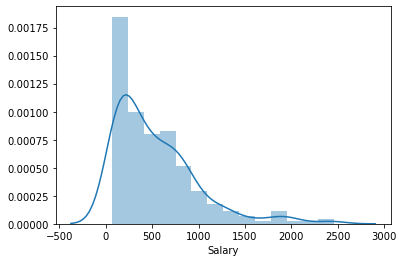

In [10]:
sns.distplot(df["Salary"])
plt.show()

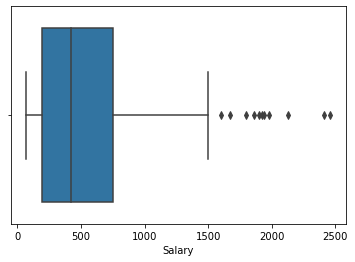

In [11]:
sns.boxplot(df["Salary"])
plt.show()

In [12]:
#kategorik ve nümerik değişkenleri alalım.

def grab_col_names(dataframe, cat_th = 10, car_th = 20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["float64","int64"]]
    cat_but_car = [col for col in cat_cols if dataframe[col].nunique() > 20]
    
    cat_cols = cat_cols + num_but_cat
    
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [13]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


In [14]:
num_cols

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'Salary']

In [15]:
def summary_cat_cols(dataframe, target, categorical_cols):
    for col in categorical_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"Count": dataframe[col].value_counts(),
                           "Ratio": dataframe[col].value_counts() / len(dataframe),
                           "Target_Mean": dataframe.groupby(col)[target].agg("mean")}), end = "\n\n\n")

In [16]:
summary_cat_cols(df, "Salary", cat_cols)

League : 2
        Count  Ratio  Target_Mean
League                           
A         175  0.543      542.000
N         147  0.457      529.117


Division : 2
   Count  Ratio  Target_Mean
E    157  0.488      624.271
W    165  0.512      450.877


NewLeague : 2
           Count  Ratio  Target_Mean
NewLeague                           
A            176  0.547      537.113
N            146  0.453      534.554




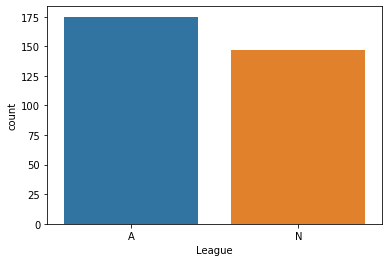

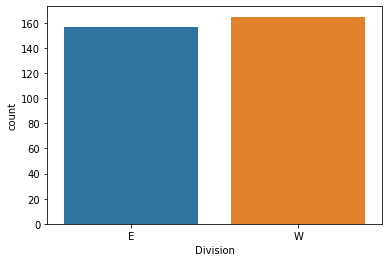

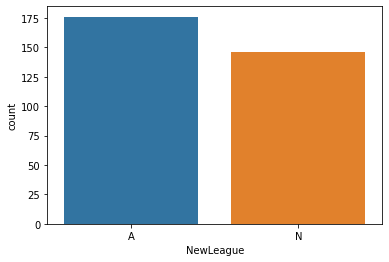

In [17]:
for col in cat_cols:
    sns.countplot(x = df[col], data = df)
    plt.show(block = True)

In [18]:
def num_summary(dataframe, numerical_col, plot  = False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T, end="\n\n")

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

count   322.000
mean    380.929
std     153.405
min      16.000
5%      161.000
10%     194.100
20%     221.800
30%     281.300
40%     321.800
50%     379.500
60%     430.200
70%     490.000
80%     535.600
90%     584.900
95%     609.900
99%     658.590
max     687.000
Name: AtBat, dtype: float64



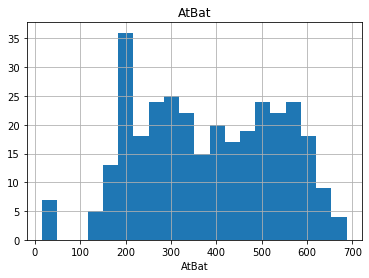

count   322.000
mean    101.025
std      46.455
min       1.000
5%       39.000
10%      45.100
20%      57.000
30%      70.000
40%      82.000
50%      96.000
60%     113.000
70%     128.700
80%     144.000
90%     163.000
95%     174.000
99%     210.790
max     238.000
Name: Hits, dtype: float64



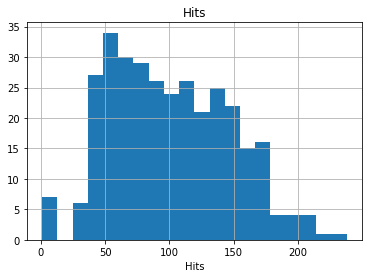

count   322.000
mean     10.770
std       8.709
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       5.000
40%       6.000
50%       8.000
60%      10.600
70%      14.000
80%      18.000
90%      24.000
95%      28.950
99%      33.000
max      40.000
Name: HmRun, dtype: float64



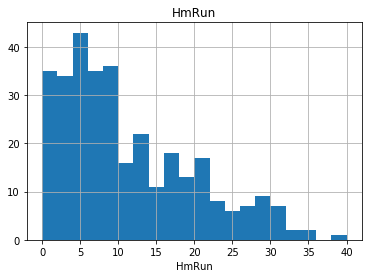

count   322.000
mean     50.910
std      26.024
min       0.000
5%       17.000
10%      20.100
20%      27.000
30%      33.000
40%      41.000
50%      48.000
60%      55.600
70%      66.000
80%      75.800
90%      89.000
95%      94.000
99%     107.790
max     130.000
Name: Runs, dtype: float64



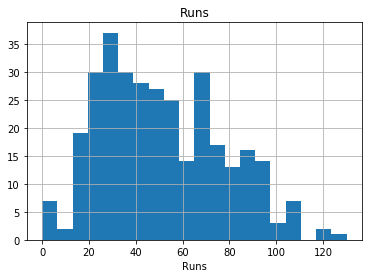

count   322.000
mean     48.028
std      26.167
min       0.000
5%       14.000
10%      19.000
20%      26.000
30%      30.000
40%      36.400
50%      44.000
60%      49.000
70%      58.000
80%      73.000
90%      86.000
95%      96.000
99%     112.370
max     121.000
Name: RBI, dtype: float64



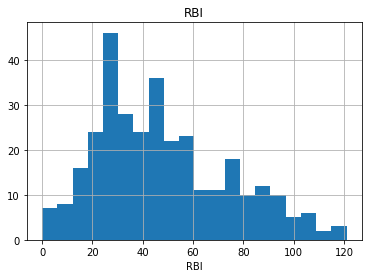

count   322.000
mean     38.742
std      21.639
min       0.000
5%       11.050
10%      15.000
20%      20.000
30%      24.000
40%      30.000
50%      35.000
60%      40.000
70%      48.700
80%      59.000
90%      69.900
95%      78.000
99%      93.580
max     105.000
Name: Walks, dtype: float64



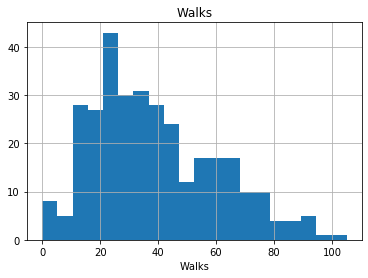

count   322.000
mean      7.444
std       4.926
min       1.000
5%        1.000
10%       2.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       7.600
70%      10.000
80%      12.000
90%      15.000
95%      17.000
99%      19.790
max      24.000
Name: Years, dtype: float64



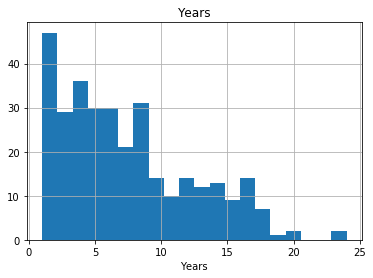

count     322.000
mean     2648.683
std      2324.206
min        19.000
5%        216.500
10%       342.200
20%       667.600
30%       963.400
40%      1402.200
50%      1928.000
60%      2654.000
70%      3365.000
80%      4483.000
90%      6123.400
95%      7125.600
99%      8749.970
max     14053.000
Name: CAtBat, dtype: float64



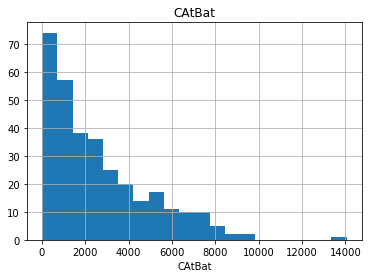

count    322.000
mean     717.571
std      654.473
min        4.000
5%        54.000
10%       86.000
20%      164.600
30%      238.000
40%      355.800
50%      508.000
60%      708.200
70%      911.100
80%     1229.200
90%     1659.600
95%     2017.150
99%     2500.340
max     4256.000
Name: CHits, dtype: float64



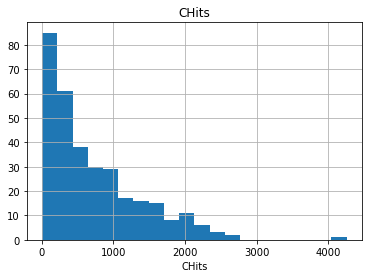

count   322.000
mean     69.491
std      86.266
min       0.000
5%        2.000
10%       4.000
20%      10.200
30%      16.300
40%      27.400
50%      37.500
60%      51.200
70%      72.400
80%     103.800
90%     194.900
95%     265.650
99%     373.120
max     548.000
Name: CHmRun, dtype: float64



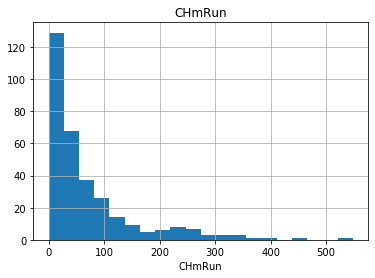

count    322.000
mean     358.795
std      334.106
min        1.000
5%        27.000
10%       38.100
20%       80.400
30%      117.300
40%      181.000
50%      247.000
60%      333.000
70%      443.400
80%      627.200
90%      895.700
95%     1032.300
99%     1174.370
max     2165.000
Name: CRuns, dtype: float64



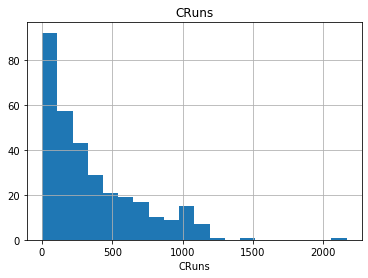

count    322.000
mean     330.118
std      333.220
min        0.000
5%        22.050
10%       34.100
20%       70.200
30%      106.300
40%      149.000
50%      220.500
60%      303.600
70%      379.100
80%      496.200
90%      861.600
95%     1071.750
99%     1310.850
max     1659.000
Name: CRBI, dtype: float64



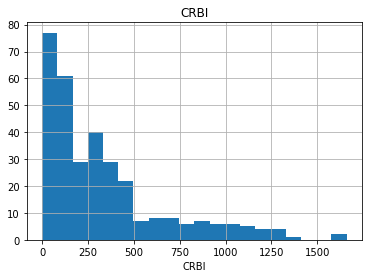

count    322.000
mean     260.239
std      267.058
min        0.000
5%        15.050
10%       30.100
20%       55.000
30%       82.000
40%      117.400
50%      170.500
60%      226.600
70%      300.700
80%      421.000
90%      643.900
95%      817.600
99%     1139.140
max     1566.000
Name: CWalks, dtype: float64



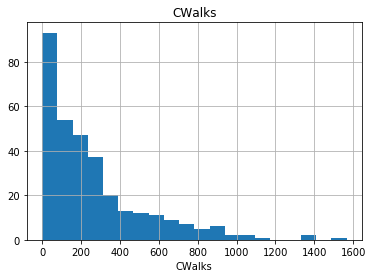

count    322.000
mean     288.938
std      280.705
min        0.000
5%        33.200
10%       62.200
20%       99.600
30%      132.000
40%      167.000
50%      212.000
60%      257.400
70%      303.000
80%      365.800
90%      685.600
95%      910.650
99%     1301.190
max     1378.000
Name: PutOuts, dtype: float64



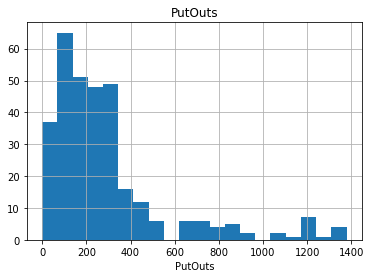

count   322.000
mean    106.913
std     136.855
min       0.000
5%        0.000
10%       2.000
20%       5.200
30%       9.000
40%      15.400
50%      39.500
60%      76.800
70%     134.800
80%     210.800
90%     353.300
95%     431.450
99%     478.160
max     492.000
Name: Assists, dtype: float64



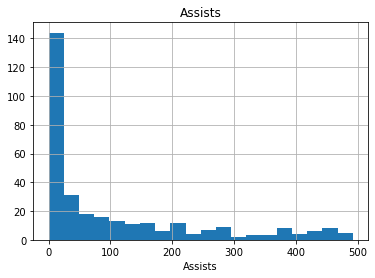

count   322.000
mean      8.040
std       6.368
min       0.000
5%        0.000
10%       1.000
20%       3.000
30%       4.000
40%       5.000
50%       6.000
60%       8.000
70%      10.000
80%      13.000
90%      17.000
95%      20.000
99%      25.790
max      32.000
Name: Errors, dtype: float64



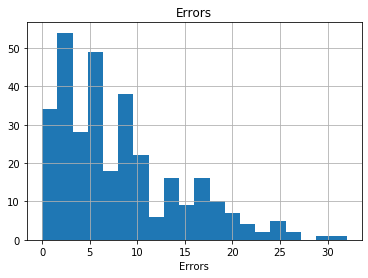

count    263.000
mean     535.926
std      451.119
min       67.500
5%        86.600
10%      100.000
20%      155.000
30%      221.000
40%      300.000
50%      425.000
60%      538.000
70%      700.000
80%      809.000
90%     1048.667
95%     1346.000
99%     2032.887
max     2460.000
Name: Salary, dtype: float64



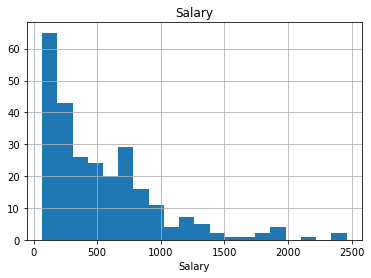

In [19]:
for col in num_cols:
    num_summary(df, col, True)

In [20]:
#df.loc çalışma mantığı -> hits 237den yüksek olanın maaşı
df.loc[(df["Hits"] > 237), "Salary"]

82   1975.000
Name: Salary, dtype: float64

In [21]:
#aykırı değer analizi bakalım.

def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] < up_limit), variable] = up_limit
    
def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis = None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index = False):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))].head())
    else:
        print(dataframe[((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))])
        
    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [22]:
for col in num_cols:
    print(col, check_outlier(df, col, q1=0.1, q3=0.9))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits True
CHmRun True
CRuns False
CRBI False
CWalks True
PutOuts False
Assists False
Errors False
Salary False


In [23]:
df["Salary"].isnull()

0       True
1      False
2      False
3      False
4      False
       ...  
317    False
318    False
319    False
320    False
321    False
Name: Salary, Length: 322, dtype: bool

(322, 20)
(308, 20)


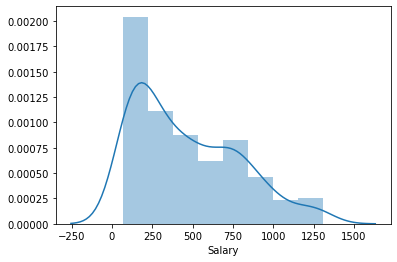

In [24]:
print(df.shape)
df = df[(df['Salary'] < 1350) | (df['Salary'].isnull())]  # Eksik değerleri de istiyoruz.
print(df.shape)
sns.distplot(df.Salary)
plt.show()

In [25]:
for col in num_cols:
    if check_outlier(df, col, q1=0.05, q3=0.95):
        replace_with_thresholds(df, col, q1=0.05, q3=0.95)

for col in num_cols:
    print(col, check_outlier(df, col, q1=0.05, q3=0.95))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
Salary False


In [26]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
    
missing_values_table(df)

        n_miss  ratio
Salary      59 19.160


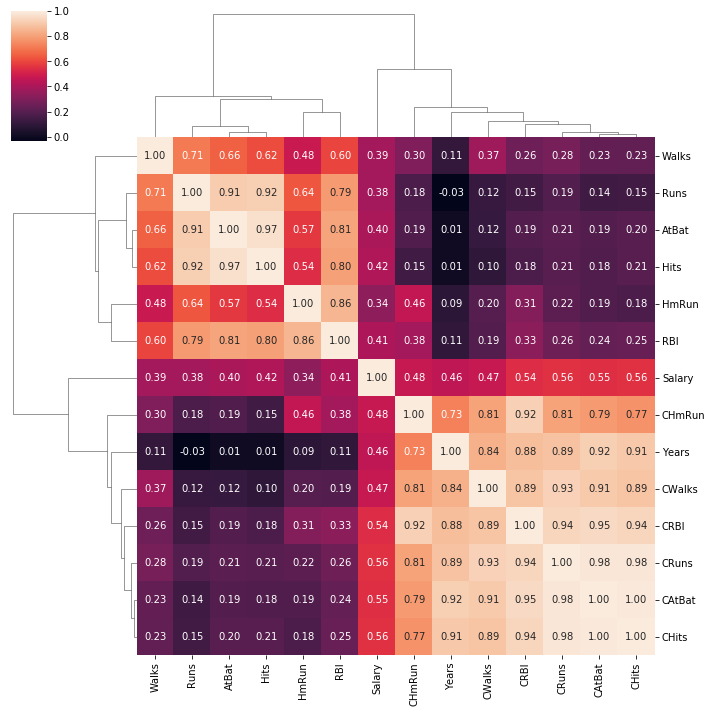

['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

In [27]:
#korelasyon bakalım
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

def target_correlation_matrix(dataframe, corr_th=0.5, target="Salary"):
    corr = dataframe.corr()
    corr_th = corr_th
    try:
        filter = np.abs(corr[target]) > corr_th
        corr_features = corr.columns[filter].tolist()
        sns.clustermap(dataframe[corr_features].corr(), annot=True, fmt=".2f")
        plt.show()
        return corr_features
    except:
        print("Yüksek threshold değeri, corr_th değerinizi düşürün!")


target_correlation_matrix(df, corr_th=0.3, target="Salary")
high_correlated_cols(df, plot=False, corr_th=0.90)

In [28]:
#veri ön işleme (domain bilgisi gerekiyor. kodları hazır aldım.)

df['NEW_HitRatio'] = df['Hits'] / df['AtBat']
df['NEW_RunRatio'] = df['HmRun'] / df['Runs']
df['NEW_CHitRatio'] = df['CHits'] / df['CAtBat']
df['NEW_CRunRatio'] = df['CHmRun'] / df['CRuns']

df['NEW_Avg_AtBat'] = df['CAtBat'] / df['Years']
df['NEW_Avg_Hits'] = df['CHits'] / df['Years']
df['NEW_Avg_HmRun'] = df['CHmRun'] / df['Years']
df['NEW_Avg_Runs'] = df['CRuns'] / df['Years']
df['NEW_Avg_RBI'] = df['CRBI'] / df['Years']
df['NEW_Avg_Walks'] = df['CWalks'] / df['Years']

In [29]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first = True)

In [30]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_HitRatio,NEW_RunRatio,NEW_CHitRatio,NEW_CRunRatio,NEW_Avg_AtBat,NEW_Avg_Hits,NEW_Avg_HmRun,NEW_Avg_Runs,NEW_Avg_RBI,NEW_Avg_Walks,League_N,Division_W,NewLeague_N
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20,nan,0.225,0.033,0.225,0.033,293.000,66.000,1.000,30.000,29.000,14.000,0,0,0
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.000,0.257,0.292,0.242,0.215,246.357,59.643,4.929,22.929,29.571,26.786,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.000,0.271,0.273,0.281,0.281,541.333,152.333,21.000,74.667,88.667,87.667,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.000,0.284,0.308,0.280,0.272,511.636,143.182,20.455,75.273,76.182,32.182,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.500,0.271,0.256,0.255,0.250,198.000,50.500,6.000,24.000,23.000,16.500,1,0,1


In [31]:
df_null = df[df["Salary"].isnull()]
df.dropna(inplace = True)

In [32]:
y = df["Salary"]
X = df.drop("Salary", axis = 1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [42]:
#tüm modelleri bir arada bir fonksiyonda çalıştıralım.
def all_models(X, y, test_size=0.2, random_state=42, classification=True):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
        roc_auc_score, confusion_matrix, classification_report, plot_roc_curve, mean_squared_error

    # Tum Base Modeller (Classification)
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from catboost import CatBoostClassifier
    from lightgbm import LGBMClassifier
    from sklearn.svm import SVC

    # Tum Base Modeller (Regression)
    from catboost import CatBoostRegressor
    from lightgbm import LGBMRegressor
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.svm import SVR
    from sklearn.tree import DecisionTreeRegressor
    from xgboost import XGBRegressor

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)
    all_models = []

    if classification:
        models = [('LR', LogisticRegression(random_state=random_state)),
                  ('KNN', KNeighborsClassifier()),
                  ('CART', DecisionTreeClassifier(random_state=random_state)),
                  ('RF', RandomForestClassifier(random_state=random_state)),
                  ('SVM', SVC(gamma='auto', random_state=random_state)),
                  ('XGB', GradientBoostingClassifier(random_state=random_state)),
                  ("LightGBM", LGBMClassifier(random_state=random_state)),
                  ("CatBoost", CatBoostClassifier(verbose=False, random_state=random_state))]

        for name, model in models:
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            acc_train = accuracy_score(y_train, y_pred_train)
            acc_test = accuracy_score(y_test, y_pred_test)
            values = dict(name=name, acc_train=acc_train, acc_test=acc_test)
            all_models.append(values)

        sort_method = False
    else:
        models = [('LR', LinearRegression()),
                  ("Ridge", Ridge()),
                  ("Lasso", Lasso()),
                  ("ElasticNet", ElasticNet()),
                  ('KNN', KNeighborsRegressor()),
                  ('CART', DecisionTreeRegressor()),
                  ('RF', RandomForestRegressor()),
                  ('SVR', SVR()),
                  ('GBM', GradientBoostingRegressor()),
                  ("XGBoost", XGBRegressor()),
                  ("LightGBM", LGBMRegressor()),
                  ("CatBoost", CatBoostRegressor(verbose=False))]

        for name, model in models:
            model.fit(X_train, y_train)
            y_pred_test = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            values = dict(name=name, RMSE_TRAIN=rmse_train, RMSE_TEST=rmse_test)
            all_models.append(values)

        sort_method = True
    all_models_df = pd.DataFrame(all_models)
    all_models_df = all_models_df.sort_values(all_models_df.columns[2], ascending=sort_method)
    print(all_models_df)
    return all_models_df

In [43]:
all_models = all_models(X, y, test_size=0.2, random_state=42, classification=False)

          name  RMSE_TRAIN  RMSE_TEST
11    CatBoost       7.011    148.859
6           RF      70.036    156.879
10    LightGBM      64.236    163.018
9      XGBoost       0.001    164.370
8          GBM      40.109    164.583
4          KNN     177.745    191.835
5         CART       0.000    199.659
2        Lasso     230.818    215.820
1        Ridge     230.053    216.270
3   ElasticNet     232.009    221.789
0           LR     227.992    222.488
7          SVR     315.161    316.731


In [44]:
all_models

,name,RMSE_TRAIN,RMSE_TEST
11,CatBoost,7.011,148.859
6,RF,70.036,156.879
10,LightGBM,64.236,163.018
9,XGBoost,0.001,164.370
8,GBM,40.109,164.583
4,KNN,177.745,191.835
5,CART,0.000,199.659
2,Lasso,230.818,215.820
1,Ridge,230.053,216.270
3,ElasticNet,232.009,221.789


In [40]:
#RF modelini tune edelim.
rf_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)

rf_params = {"max_depth": [4, 5, 7, 10],
             "max_features": [4, 5, 6, 8, 10, 12],
             "n_estimators": [80, 100, 150, 250, 400, 500],
             "min_samples_split": [8, 10, 12, 15]}

rf_cv_model = GridSearchCV(rf_model, rf_params, cv = 10, n_jobs = -1).fit(X_train, y_train)
rf_cv_model.best_params_

{'max_depth': 7,
 'max_features': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

In [45]:
rf_tuned = RandomForestRegressor(max_depth = 7, max_features = 4, n_estimators = 150, min_samples_split = 8, random_state = 42).fit(X_train, y_train)

In [48]:
#train hatası
y_pred = rf_tuned.predict(X_train)
print("RF Tuned Model Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

RF Tuned Model Train RMSE: 106.35652629246664


In [49]:
#test hatası
y_pred = rf_tuned.predict(X_test)
print("RF Tuned Model Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

RF Tuned Model Test RMSE: 158.04296075452135


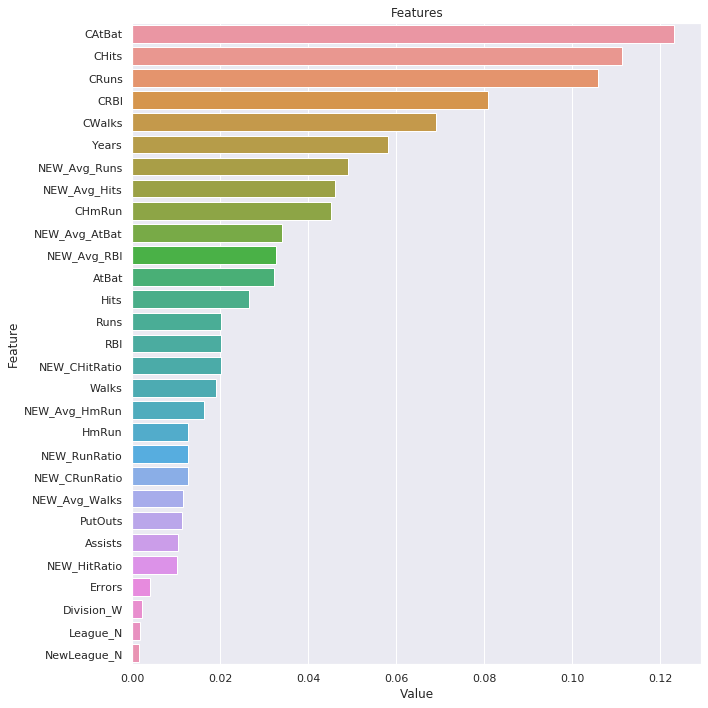

In [50]:
#modelimizde hangi özellikler daha önemli ona bakalım.

def plot_importance(model, features, num=len(X), save=False):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_tuned, X_train)

In [51]:
#tuned modelin kaydedilmesi

import pickle
pickle.dump(rf_tuned, open("rf_final_model.pkl", 'wb'))

In [52]:
#tuned modelin yüklenmesi
df_prep = pickle.load(open('rf_final_model.pkl', 'rb'))

In [53]:
df_prep

RandomForestRegressor(max_depth=7, max_features=4, min_samples_split=8,
                      n_estimators=150, random_state=42)

In [65]:
y_test[0:2]

186   300.000
7     100.000
Name: Salary, dtype: float64

In [66]:
rf_model.predict(X_test)[0:2]

array([347.925, 101.83 ])